In [29]:
options(repr.plot.width=10, repr.plot.height=5, jupyter.plot_mimetypes='image/svg+xml')
source('common.r')
out <- function(obj) write(obj, stdout())

# Raw Mix

In [40]:
source('common.r')
d <- data.ipa.rawmix(where="datatype='counter' and ipa_duration=60 and (ipa_version = 'v5.0')")
out("data:   " + nrow(d))

d$grp <- d$bound
d$facet <- factor(d$honeycomb_mode)
d$x <- d$load

d$inconsistent <- d$counters_inconsistent_count
d$consistent <- d$counters_consistent_count
d$inconsistent_fraction <- d$inconsistent / (d$inconsistent + d$consistent)

d$fraction_immediate <- d$res_immediates_total / d$res_incrs_total

d$overall_latency_mean <- 
    d$timers_read_latency_mean * num(d$ipa_rawmix_counter_mix_read) + 
    d$timers_incr_latency_mean * num(d$ipa_rawmix_counter_mix_incr)

d$overall_rate_mean <- d$timers_read_latency_mean_rate + d$timers_incr_latency_mean_rate

s <- subset(d, 
  #  grepl('normal|slowpoke_flat', honeycomb_mode)
mix == 'default' #& grepl('\\{.*\\}', containers)
            & !is.na(counters_contains_count)
 #& grepl('(con|lat)|v3.1#tol', x(ipa_version,ipa_bound))
            & lease == '0ms'
 #& (!grepl('tol', ipa_bound) | ipa_lease_period == '200ms' & ipa_reservations_lease == '10s')
)
out("subset: " + nrow(s))

The following `from` values were not present in `x`: normal#512, normal#4096, world#512
The following `from` values were not present in `x`: consistency:strongwrite, consistency:weak
The following `from` values were not present in `x`: no_size, read_heavy


data:   528
subset: 398


In [10]:
s$percent_weak <- (1 - s$read_strong_fraction) * 100

s.l <- subset(s, 
  !is.na(condition) 
  & grepl('cons|lat', ipa_bound)
  & grepl('flat5|slowpoke|google', honeycomb_mode)
)
m <- melt.by(s.l, 'measure', 'overall_latency_mean|percent_weak')
m$measure <- factor.remap(m$measure, list(
  overall_latency_mean='Mean latency (ms)',
  percent_weak='% weak consistency'
))

The following `from` values were not present in `x`: overall_latency_mean, percent_weak


In [15]:
fields <- names(s.l)[grep('overall_latency_mean|percent_weak', names(s.l))]
m <- melt(s.l, measure=fields)


In [72]:
#sql("SELECT load, ipa_bound, honeycomb_mode, round(res_cass_op_lat_mean,2) as cass_op, round(res_weak_read_lat_mean,2) as weak_read, round(res_strong_read_lat_mean,2) as strong_read, round(res_weak_write_lat_mean,2) as weak_write, round(res_cached_read_lat_mean,2) as strong_write FROM s WHERE ipa_bound LIKE '%tolerance%' ORDER BY honeycomb_mode")

In [19]:
#sql("SELECT load, ipa_bound, honeycomb_mode as honeycomb, round(timers_read_latency_mean,2) as mean_lat, round(avg(res_immediates_total/res_incrs_total),3) as immed, round(avg(res_refreshes_total/res_incrs_total),3) as refresh, round(avg(res_out_of_bounds_total/res_incrs_total),3) as obounds, res_incrs_total as incrs, round(avg(res_cached_reads_total/res_reads_total),3) as cached FROM s WHERE ipa_bound LIKE '%tolerance%' and ipa_lease_period = '200ms' GROUP BY load, ipa_bound, honeycomb ORDER BY honeycomb_mode")

Warning message:
: replacing previous import by ‘ggplot2::unit’ when loading ‘Hmisc’Warning message:
: replacing previous import by ‘ggplot2::arrow’ when loading ‘Hmisc’Warning message:
: replacing previous import by ‘scales::alpha’ when loading ‘Hmisc’

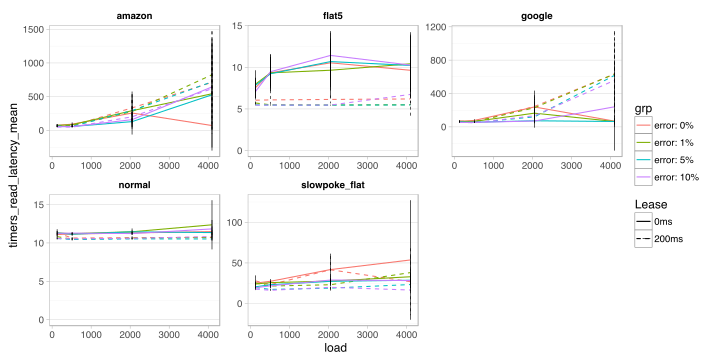

In [5]:
source('common.r')
ggplot(subset(d, 
              #!is.na(condition) & 
              ipa_version == 'v3.1'
              & mix == 
              & grepl('tol', ipa_bound)
            ), aes(
#    y = overall_latency_mean,
#    y = timers_read_latency_mean,
    y = timers_read_latency_mean,
    x=load, color=grp, fill=grp, linetype=ipa_lease_period
))+
    stat_summary(geom='line', fun.y=mean)+
    stat_summary(fun.data=mean_cl_normal, geom='errorbar', size=0.3, width=0.2, color='black')+
    facet_wrap(~honeycomb_mode, scale="free")+
    theme_mine()+
expand_limits(y=0)+
#    theme.bar()
#    ipa.scales()+
    scale_linetype_manual(values=c('0ms'=1, '200ms'=2), name = 'Lease')

In [18]:
unique(vals(bounds))

[1] "strong"         "strong (write)" "error: 0%"      "error: 1%"     
 [5] "error: 5%"      "error: 10%"     "latency: 50ms"  "latency: 20ms" 
 [9] "latency: 10ms"  "weak/strong"    "weak"

In [26]:
s.err <- subset(d,
  !is.na(condition) 
  & honeycomb_mode != 'normal'
  & ipa_bound != 'consistency:weak'
  & grepl('tol', ipa_bound)
  & grepl('Uniform', condition)
)
ddply(s.err, .(bound, condition, mix), summarize, interval=mean(interval_mean))

,bound,condition,mix,interval
1,error: 0%,Uniform (5ms),default,0
2,error: 0%,Uniform (5ms),read_heavy,0
3,error: 1%,Uniform (5ms),default,5.376896
4,error: 1%,Uniform (5ms),read_heavy,0.02857316
5,error: 5%,Uniform (5ms),default,45.72836
6,error: 5%,Uniform (5ms),read_heavy,1.358134
7,error: 10%,Uniform (5ms),default,98.24645
8,error: 10%,Uniform (5ms),read_heavy,3.477913


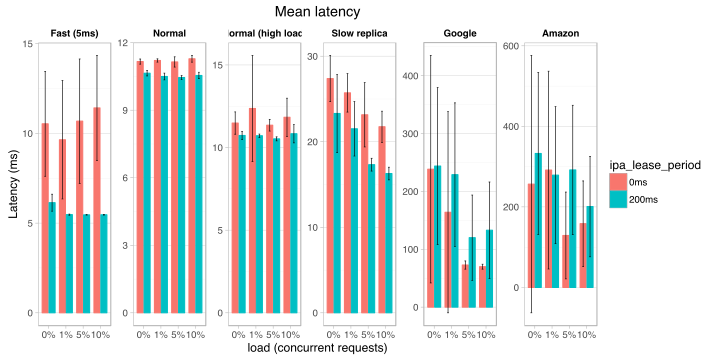

In [27]:
source('common.r')

s$tol <- factor.remap(s$ipa_bound, list('tolerance:0'='0%', 'tolerance:0.01'='1%', 'tolerance:0.05'='5%', 'tolerance:0.1'='10%'))
s$caching <- factor.remap(s$ipa_lease_period, list('0ms'='n', '200ms'='y'))

ggplot(subset(s, !is.na(condition)), aes(
#    y = overall_latency_mean,
    y = timers_read_latency_mean,
    x=tol, color=ipa_lease_period, fill=ipa_lease_period, group=grp
))+
    #stat_summary(geom='bar', fun.y=mean, size=0.5, width=0.7)+
    geom_meanbar(position=position_dodge(0.8))+
    ggtitle('Mean latency')+
    xlab('load (concurrent requests)')+
    ylab('Latency (ms)')+
    facet_wrap(~condition, ncol=6, scale="free")+
    theme_mine()
    #theme.bar()
#    ipa.scales()

Warning message:
: Removed 6 rows containing missing values (geom_errorbar).

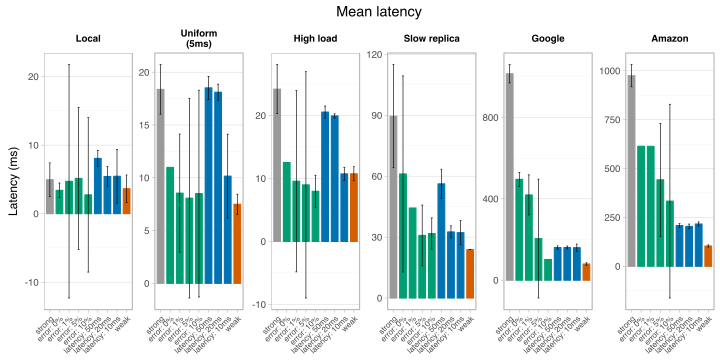

In [41]:
source('common.r')

ggplot(subset(s, !is.na(condition)), aes(
    y = overall_latency_mean,
#    y = timers_read_latency_mean,
    x=grp, color=grp, fill=grp, group=grp
))+
    #stat_summary(geom='bar', fun.y=mean, size=0.5, width=0.7)+
    geom_meanbar()+
    ggtitle('Mean latency')+
    xlab('load (concurrent requests)')+
    ylab('Latency (ms)')+
    facet_wrap(~condition, ncol=6, scale="free")+
    theme_mine()+
    theme.bar()+
    ipa.scales()

In [ ]:
ddply(subset(s,
  !is.na(condition) 
  & honeycomb_mode != 'normal'
  & ipa_bound != 'consistency:weak'
  & grepl('tol', ipa_bound)
  & grepl('Google', condition)
), .(bound, condition, mix), summarize, interval=mean(interval_mean))

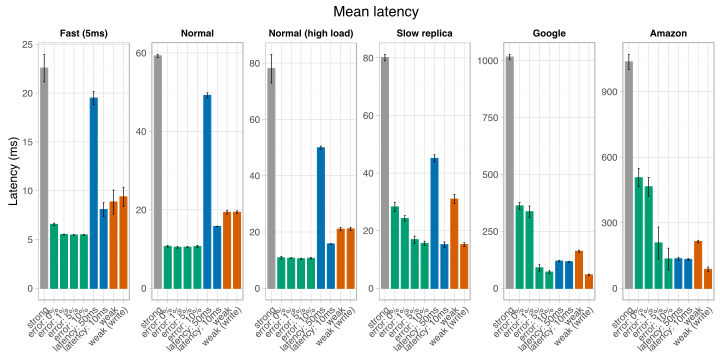

In [13]:
source('common.r')

ggplot(subset(s, !is.na(condition)), aes(
#    y = overall_latency_mean,
    y = timers_read_latency_mean,
    x=grp, color=grp, fill=grp, group=grp
))+
    #stat_summary(geom='bar', fun.y=mean, size=0.5, width=0.7)+
    geom_meanbar()+
    ggtitle('Mean latency')+
    xlab('load (concurrent requests)')+
    ylab('Latency (ms)')+
    facet_wrap(~condition, ncol=6, scale="free")+
    theme_mine()+
    theme.bar()+
    ipa.scales()

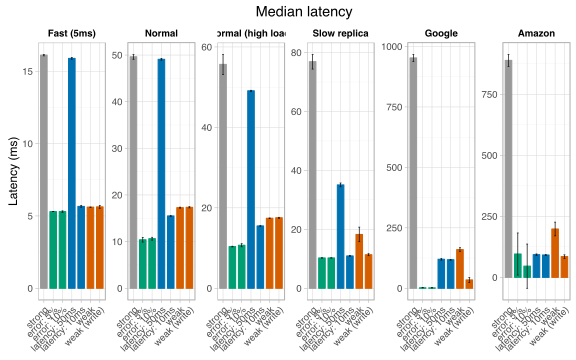

In [47]:
source('common.r')

ggplot(subset(s, !is.na(condition)), aes(
#    y = value,
#    y = overall_latency_mean,
    y = timers_read_latency_p50,
    x=grp, color=grp, fill=grp, group=grp
))+
    #stat_summary(geom='bar', fun.y=mean, size=0.5, width=0.7)+
    geom_meanbar()+
    ggtitle('Median latency')+
    xlab('load (concurrent requests)')+
    ylab('Latency (ms)')+
    facet_wrap(~condition, ncol=6, scale="free")+
    theme_mine()+
    theme.bar()+
    ipa.scales()

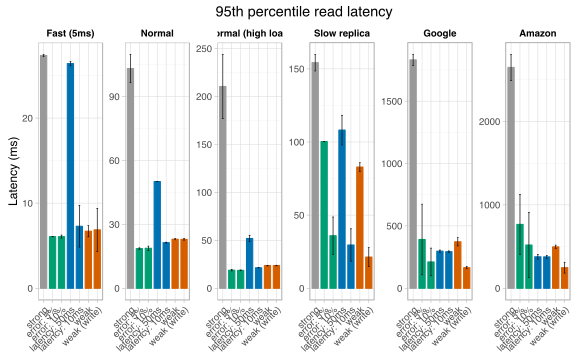

In [49]:
source('common.r')

ggplot(subset(s, !is.na(condition)), aes(
    y = timers_read_latency_p95,
    x=grp, color=grp, fill=grp, group=grp
))+
    geom_meanbar()+ #stat_summary(geom='bar', fun.y=mean, size=0.5, width=0.7)+
    ggtitle('95th percentile read latency')+
    ylab('Latency (ms)')+
    facet_wrap(~condition, ncol=6, scale="free")+
    theme_mine()+
    theme.bar()+
    ipa.scales()

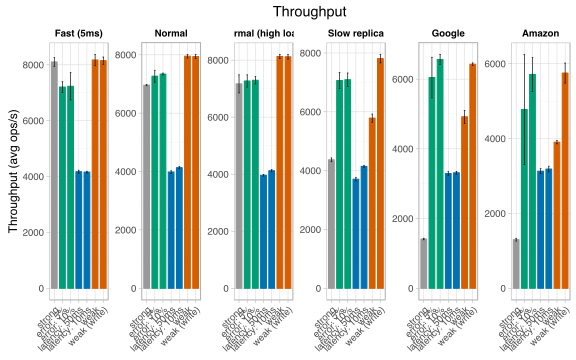

In [50]:
ggplot(subset(s, !is.na(condition)), aes(
    x=grp, y=overall_rate_mean, color=grp, fill=grp, group=grp
))+
    #stat_summary(geom='bar', fun.y=mean, width=0.7)+
    geom_meanbar()+
    ggtitle('Throughput')+
    ylab('Throughput (avg ops/s)')+
    facet_wrap(~condition, scale="free", ncol=6)+
    theme_mine()+
    theme.bar()+
    ipa.scales()

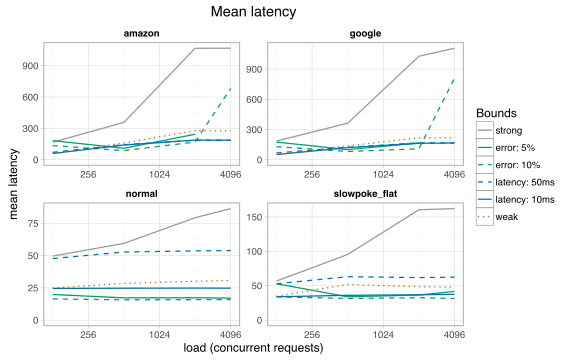

In [126]:
source('common.r')
ggplot(subset(s, x <= 4096), aes(
    x=x, y=overall_latency_mean, color=grp, fill=grp, linetype=grp, group=grp
))+
    stat_summary(geom='line', fun.y=mean, size=0.6)+
    ggtitle('Mean latency')+
    xlab('load (concurrent requests)')+
    ylab('mean latency')+
    scale_x_continuous(trans=log2_trans())+
    facet_wrap(~honeycomb_mode, scales="free")+
    theme_mine()+
    ipa.scales()

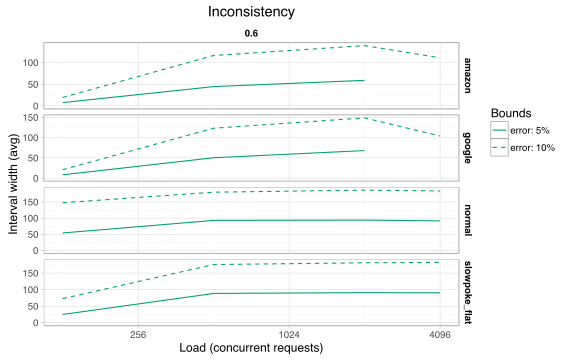

In [127]:
ggplot(subset(s, grepl('tolerance:',ipa_bound)), aes(
    x = x, y= histograms_interval_width_mean, color=grp, fill=grp, group=grp, linetype=grp
))+
    stat_summary(geom='line', fun.y=mean)+
    ggtitle('Inconsistency')+
    xlab('Load (concurrent requests)')+ 
    ylab('Interval width (avg)')+
    scale_x_continuous(trans=log2_trans())+
    facet_grid(honeycomb_mode~ipa_zipf, scales="free")+
    ipa.scales()+
    theme_mine()

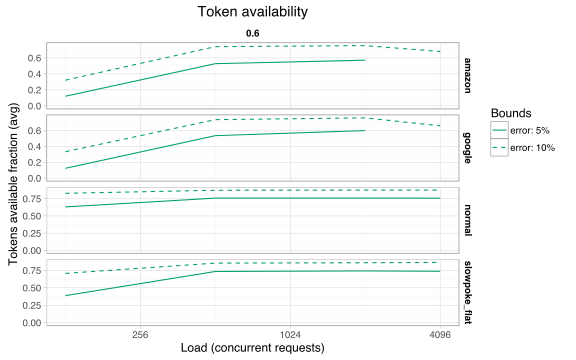

In [128]:
ggplot(subset(s, grepl('tolerance:',ipa_bound)), aes(
    x = x, y = fraction_immediate, color=grp, fill=grp, group=grp, linetype=grp
))+
    stat_summary(geom='line', fun.y=mean)+
    ggtitle('Token availability')+
    xlab('Load (concurrent requests)')+
    ylab('Tokens available fraction (avg)')+
    scale_x_continuous(trans=log2_trans())+
    facet_grid(honeycomb_mode~ipa_zipf, scales="free")+
    ipa.scales()+
    theme_mine()

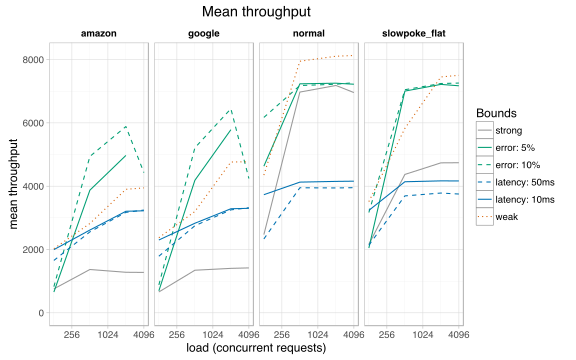

In [129]:
ggplot(subset(s, x <= 4096), aes(
    x=x, y=overall_rate_mean, color=grp, fill=grp, group=grp, linetype=grp
))+
    stat_summary(geom='line', fun.y=mean)+
    ggtitle('Mean throughput')+
    xlab('load (concurrent requests)')+
    ylab('mean throughput')+
    scale_x_continuous(trans=log2_trans())+
    facet_grid(~honeycomb_mode, scales="free")+
    ipa.scales()+
    theme_mine()

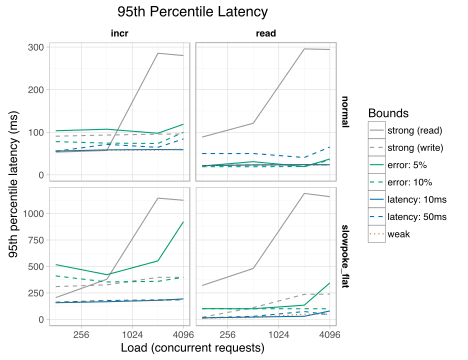

In [28]:
p = "95"
ggplot(melt.by(s, 'op', 'timers_(read|incr)_latency_p'+p+'$'), aes(
    x=x, y=value, color=grp, fill=grp, group=grp, linetype=grp
))+
    stat_summary(geom='line', fun.y=mean)+
    ggtitle(p+'th Percentile Latency')+
    xlab('Load (concurrent requests)')+
    ylab(p+'th percentile latency (ms)')+
    scale_x_continuous(trans=log2_trans())+
    facet_grid(honeycomb_mode~op, scale="free")+
    ipa.scales()+
    theme_mine()

In [66]:
r <- data.ipa.rawmix(where="datatype='counter' and ipa_duration=60 and ipa_version = 'v1.9' and ipa_bound LIKE 'tolerance%'")

The following `from` values were not present in `x`: world#128
The following `from` values were not present in `x`: consistency:strong, consistency:strongwrite, latency:50ms, latency:10ms, consistency:weak


In [67]:
sql("SELECT load, ipa_bound, honeycomb_mode, timers_read_latency_mean as mean_lat, round(res_immediates_total/res_incrs_total,4) as immed, round(res_refreshes_total/res_incrs_total,4) as refresh, round(res_out_of_bounds_total/res_incrs_total,4) as out_of_bounds, res_incrs_total as incrs FROM r WHERE ipa_bound LIKE '%tolerance%' ORDER BY honeycomb_mode")

,load,ipa_bound,honeycomb_mode,mean_lat,immed,refresh,out_of_bounds,incrs
1,128,tolerance:0.1,normal,10.90409,0.8386,0.1176,0.0438,76415
2,128,tolerance:0.05,normal,12.18976,0.6965,0.1765,0.127,72226
3,512,tolerance:0.1,normal,11.03484,0.8697,0.1085,0.0218,88337
4,512,tolerance:0.05,normal,10.8847,0.7507,0.1667,0.0826,87293
5,2048,tolerance:0.1,normal,11.01613,0.8684,0.1094,0.0222,86780
6,2048,tolerance:0.05,normal,10.69321,0.7458,0.1675,0.0868,86073
7,4096,tolerance:0.05,normal,11.13091,0.7507,0.1657,0.0837,87104
8,128,tolerance:0.1,normal,10.763,0.84,0.1184,0.0416,75474
9,128,tolerance:0.05,normal,10.76421,0.7082,0.174,0.1178,75021
10,512,tolerance:0.1,normal,11.09122,0.8688,0.1102,0.021,85528


# Retwis

In [ ]:
d <- data.or.csv(
    csv = 'data/owl.csv',
    gen = function() data.owl()
)

In [ ]:
subset(d, duration == 60 & blockade == 'slow', select=c('c_reqs','ipa_consistency','op_rate'))

In [ ]:
d$x <- d$c_reqs
d$grp <- d$ipa_consistency
s <- subset(d, duration == 60 & blockade == 'slow' & !is.na(ipa_consistency))

ggplot(s, aes(x=x, y=op_rate, color=grp, fill=grp, group=grp))+
    stat_summary(geom='line', fun.y=mean)+
    xlab('system load (# concurrent requests)')+
    ylab('mean cassandra op latency (ms)')+
    my_theme()

In [ ]:
ggplot(s, aes(x=x, y=op_lat_mean, color=grp, fill=grp, group=grp))+
    stat_summary(geom='line', fun.y=mean)+
    xlab('system load (# concurrent requests)')+
    ylab('mean cassandra op latency (ms)')+
    my_theme()